# 3D Inversion of DC Resistivity Data on a Tree Mesh

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** DC resistivity, 3D inversion, weighted least-squares, tree mesh.

</br>

**Summary:** Here, DC resistivity data are inverted to recover a log-conductivity model using a weighted least-squares inversion approach. Because much of the functionality required for this tutorial was presented in the [3D Forward Simulation of DC Resistivity Data on a Tree Mesh](fwd_dcr_3d.ipynb) and [2.5D Inversion of DC Resistivity Data on a Tree Mesh](inv_dcr_2d.ipynb) tutorials, we will link to these tutorials and avoid repitition whenever possible.

</br>

**Learning Objectives:**

- Demonstrate 3D DC resistivity inversion with SimPEG.
- Discuss practical aspects of 3D DC resistivity inversion.
- Analyzing inversion outputs.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity).
We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    geometric_factor
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip_xyz
from SimPEG.utils import download, model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
try:
    import plotly
    from SimPEG.electromagnetics.static.utils.static_utils import plot_3d_pseudosection
    from IPython.core.display import display, HTML
    has_plotly = True
except ImportError:
    has_plotly = False
    pass

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 16})

C:\Users\devin\AppData\Local\Temp\ipykernel_3252\3225891296.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Load Data and Plot

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# # URL to download from repository assets
# data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/fwd_dcr_3d.tar.gz"

# # download the data
# downloaded_data = utils.download(data_source, overwrite=True)

# # unzip the tarfile
# tar = tarfile.open(downloaded_data, "r")
# tar.extractall()
# tar.close()

# # path to the directory containing our data
# dir_path = downloaded_data.split(".")[0] + os.path.sep
dir_path = './fwd_dcr_3d/'

# files to work with
topo_filename = dir_path + "topo_xyz.txt"
dc_data_filename = dir_path + "dc_data.xyz"

### Load Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray).

In [3]:
topo_xyz = np.loadtxt(str(topo_filename))

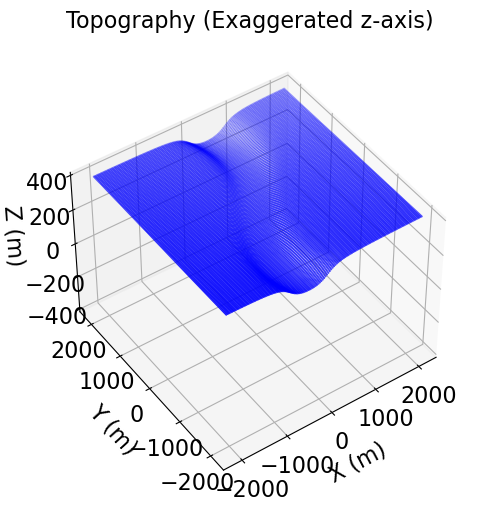

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c='b')
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel('X (m)', labelpad=10)
ax.set_ylabel('Y (m)', labelpad=10)
ax.set_zlabel('Z (m)', labelpad=10)
ax.set_title('Topography (Exaggerated z-axis)', fontsize=16, pad=-20)
ax.view_init(elev=45., azim=-125)

### Load Data

**Option A: DCIP3D formatted data**

The [read_dcip3d_ubc](myst:SimPEG#SimPEG.utils.io_utils.read_dcip3d_ubc) utility function can be used to load DC/IP data stored in a UBC-GIF formatted file. This function outputs a SimPEG [Data](myst:SimPEG#SimPEG.data.Data) object.

**Option B: Load XYZ formatted data**

For this tutorial, the observed data are organized within an XYZ formatted file. We can use the [read_dcip_xyz](myst:SimPEG#SimPEG.utils.io_utils.read_dcip_xyz) utility function to load data in this format. This function outputs a SimPEG [Data](myst:SimPEG#SimPEG.data.Data) object. The data are normalized voltages in units V/A.

In [5]:
dc_data = read_dcip_xyz(
    dc_data_filename,
    "volt",
    data_header="V/A",
    uncertainties_header="UNCERT",
    is_surface_data=False,
)

### Plot Observed Data in Pseudo-Section

Here we use the [plot_3d_pseudosection](SimPEG#SimPEG.electromagnetics.static.utils.plot_3d_pseudosection) utility function to represent the predicted data on a pseudosection. We plot the original normalized voltages. We also use the [apparent_resistivity_from_voltage](SimPEG#SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities.

In [32]:
# Convert predicted data to apparent conductivities
apparent_conductivities = 1 / apparent_resistivity_from_voltage(
    dc_data.survey,
    dc_data.dobs,
)

if has_plotly:
    fig = plot_3d_pseudosection(
        dc_data.survey,
        apparent_conductivities,
        scale="log",
        units="S/m",
        marker_opts={"colorscale": "RdYlBu_r"}
    )

    fig.update_layout(
        title_text="Apparent Conductivity",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    plotly.io.show(fig)
#     html_str = plotly.io.to_html(fig)
#     display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For normalized voltage data,** we generally apply a percent uncertainty and a very small floor uncertainty to all data. Differences in electrode spacing and subsurface conductivity result in measured voltages that span many orders of magnitude. A percent uncertainty ensures all data are fit equally. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages. Here, we apply uncertainties of 1e-7 V/A + 10 %.

**For apparent resistivity data,** we also apply a percent uncertainty and a very small floor uncertainty to all data. A percent uncertainty will fit conductive and resistive structures equally; unlike a floor uncertainty which will prioritize fitting more resistive structures. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages.

In [17]:
dc_data.standard_deviation = 1e-7 + 0.1 * np.abs(dc_data.dobs)

## Designing a (Tree) Mesh

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tree mesh](myst:discretize#discretize.TreeMesh). Because of the modular nature of SimPEG, you could define a [tensor mesh](myst:discretize#discretize.TensorMesh) instead.

**Standard approach:** The electric potential produced by a current electrode falls off as $r^{-3}$. So smaller cells are needed near the current electrodes to model the fields accurately, and larger cells can be used away from the current electrodes where the fields are smooth. Tree meshes are well-suited for DC resistivity simulation because the cell size can be increased at specified distances from the current electrodes. For DC resistivity meshing, we advise the following considerations and rules of thumb:

1. Because there are no currents in the air, we do not need to pad upwards. I.e. the top of the mesh corresponds to the top of the topography.
2. We require at least 2-3 cells between each current electrode; with more accurate results being obtained when the minimum cell size is smaller.
3. To be safe, the padding thickness should be at least 2-3 times the largest electrode spacing. 
4. The increase in cell size at increasing distancee from the current electrodes should not happen too abruptly. At each cell size, you should have a layer at least 4 cells thick before increasing the cell size.
5. Finer discretization is required when topography is significant.

**Tutorial mesh:** Here, a minimum cell width of 25 m (or 1/4 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 1000 m, so a the padding was extended at least 3000 m from the survey region. Using the [refine_surface](myst:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](myst:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](myst:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [18]:
# Defining domain size and minimum cell size
dh = 25.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0., 0., topo_xyz[:, -1].max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(
    topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False
)

# Extract unique electrode locations.
unique_locations = dc_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[6, 6, 4], finalize=False
)

# Finalize the mesh
mesh.finalize()

## Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [19]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz)

## Project Survey to Discretized Topography

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to simulating surface DC resistivity data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [20]:
dc_data.survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

### Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](myst:numpy#numpy.ndarray)) to the physical property values of all cells in the mesh. Mappings are created using the [SimPEG.maps](myst:SimPEG#SimPEG.maps.IdentityMap) module.

For DC resistivity, the model parameters define the subsurface electrical conductivity, and the electrical conductivities of the cells in the air are given a fixed value. Here, the model defines the log-conductivity values for all active cells. We use the [SimPEG.maps.ExpMap](myst:SimPEG#SimPEG.maps.ExpMap) to map from the model parameters to the conductivity values for all active cells. Then we use the [SimPEG.maps.InjectActiveCells](myst:SimPEG#SimPEG.maps.InjectActiveCells) map to project the active cell conductivities to the entire mesh. As explained in the [2.5D Forward Simulation of DC Resistivity Data on a Tree Mesh](fwd_dcr_2d.ipynb) tutorial, air cells are given a fixed value of 1e-8 S/m to ensure the forward problem is well-conditionned. And the $*$ operator is used to combine the separate mapping objects into a single mapping.

In [21]:
# Number of model parameters
n_param = np.sum(ind_active)

# Model parameters to all cells
log_conductivity_map = (
    maps.InjectActiveCells(mesh, ind_active, 1e-8) *
    maps.ExpMap(nP=n_param)
)

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. It should be noted that the staring model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For DC resistivity inversion, the starting model is frequently a halfspace estimated from the set of apparent resistivities/conductivities.

The **reference model** is used to include a-priori information. By default, the starting model is set as the reference model. The impact of the reference model on the inversion will be discussed in another tutorial.

Notice that the length of the starting and reference models is equal to the number of model parameters!!!

In [22]:
# Median apparent resistivity
median_conductivity = np.median(apparent_conductivities)

# Create staring model from log-conductivity
starting_conductivity_model = np.log(median_conductivity) * np.ones(n_param)

# Zero reference conductivity model
reference_conductivity_model = starting_conductivity_model.copy()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 2.5D DC resistivity was discussed in the [2.5D Forward Simulation of DC Resistivity Data on a Tree Mesh](fwd_dcr_2d.ipynb) tutorial. Here, we use the [Simulation2DNodel](myst:SimPEG#SimPEG.electromagnetics.static.resistivity.Simulation2DNodal) simulation which solves for the electric potential on mesh nodes.

Since our model consists of log-conductivities, we use ``sigmaMap`` to set the mapping from the model to the mesh cells. For reasonable cases, we can compute and store the Jacobian explicitly for 3D problems. By doing so, we drastically reduce the run-time of the inversion.

In [23]:
dc_simulation = dc.simulation.Simulation3DNodal(
    mesh, survey=dc_data.survey, sigmaMap=log_conductivity_map, storeJ=True
)

### Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](myst:SimPEG#SimPEG.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [24]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=dc_simulation, data=dc_data)

### Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](myst:SimPEG#SimPEG.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Length scales along x, y and z are used to balance the smallness and smoothness terms. And the reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros.

By default, the regularization acts on the model parameters; which in the case are the log-conductivities of the active cells. So we need to specify which cells are active in the regularization. And if we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [25]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=ind_active,
    length_scale_x=100.,
    length_scale_y=100.,
    length_scale_z=100.,
    reference_model=reference_conductivity_model
)

### Optimization

To understand the role of the optimization algorithm in the inversion, please visit this online resource. Here, we use the [InexactGaussNewton](myst:SimPEG#SimPEG.optimization.InexactGaussNewton) class to solve the optimization problem using the inexact Gauss Newton with conjugate gradient solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches.

In [26]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=40, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Inverse Problem

We use the [BaseInvProblem](myst:SimPEG#SimPEG.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [27]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Inversion Directives

To understand the role of directives in the inversion, please visit this online resource. Here, we apply common directives for weighted least-squares inversion of DC resistivity data and describe their roles. These are:

- [UpdateSensitivityWeights](myst:SimPEG#SimPEG.directives.UpdateSensitivityWeights): apply sensitivity weighting to counteract the natural tendancy of DC resistivity inversion to place materials near the electrodes. Since the problem is non-linear and the sensitivities are updated with every model, we set `every_iteration=True`.

- [UpdatePreconditioner](myst:SimPEG#SimPEG.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=True` because the ideal preconditioner is model-dependent.

- [BetaEstimate_ByEig](myst:SimPEG#SimPEG.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](myst:SimPEG#SimPEG.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 2 or 3 works well for DC resistivity inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](myst:SimPEG#SimPEG.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [28]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=True)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=20)
beta_schedule = directives.BetaSchedule(coolingFactor=2., coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit
]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](myst:SimPEG#SimPEG.inversion.BaseInversion) class. The inversion class must be instatiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [29]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# recovered_model_L2 = inv_L2.run(np.log(0.01) * np.ones(n_param))
recovered_log_conductivity_model = inv_L2.run(starting_conductivity_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.18e-05  1.49e+03  0.00e+00  1.49e+03    1.46e+02      0              
   1  5.18e-05  1.92e+02  1.71e+06  2.80e+02    9.41e+00      0              
   2  2.59e-05  1.82e+02  1.76e+06  2.27e+02    8.29e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.4890e+02
1 : |xc-x_last| = 2.2542e+01 <= tolX*(1+|x0|) = 1.0686e+02
0 : |proj(x-g)-x|    = 8.2908e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 8.2908e+

## Plotting Normalized Data Misfit or Predicted DC Data

To see how well the recovered model reproduces the observed data,
it is a good idea to compare the predicted and observed data.
Here, we accomplish this by plotting the normalized misfit.

In [47]:
# Predicted data from recovered model
dpred_dc = inv_prob_L2.dpred

# Compute the normalized data misfit
dc_normalized_misfit = (dc_data.dobs - dpred_dc) / dc_data.standard_deviation

if has_plotly:
    fig = plot_3d_pseudosection(
        dc_data.survey,
        dc_normalized_misfit,
        scale="linear",
        units="",
        vlim=[-2, 2],
        marker_opts={"colorscale": "RdBu"}
    )

    fig.update_layout(
        title_text="Normalized Data Misfit",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    plotly.io.show(fig)
#     html_str = plotly.io.to_html(fig)
#     display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

## Recreate True Conductivity Model




In [39]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
background_value = 1e-2
conductor_value = 1e-1
resistor_value = 1e-3

# Define model
true_conductivity_model = background_value * np.ones(n_param)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-350.0, 0.0, 100.0], 160.0, mesh.cell_centers[ind_active, :]
)
true_conductivity_model[ind_conductor] = conductor_value

ind_resistor = model_builder.get_indices_sphere(
    np.r_[350.0, 0.0, 100.0], 160.0, mesh.cell_centers[ind_active, :]
)
true_conductivity_model[ind_resistor] = resistor_value

## Plotting True and Recovered Conductivity Model




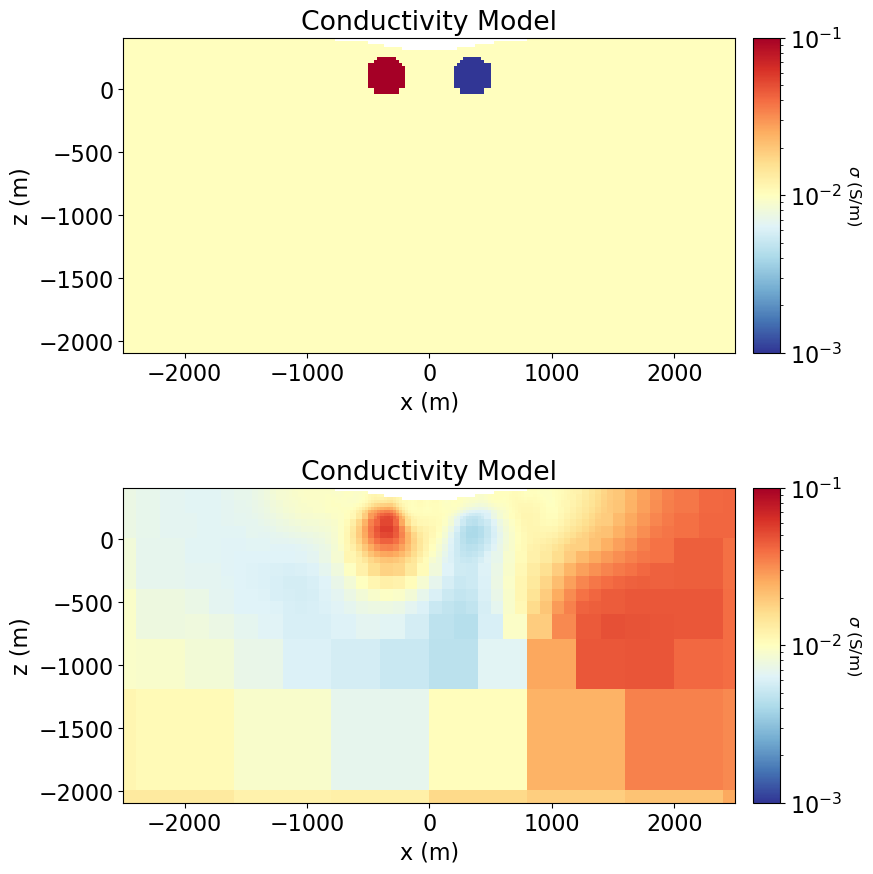

In [50]:
norm = LogNorm(vmin=1e-3, vmax=1e-1)

fig = plt.figure(figsize=(9, 9))
ax1 = 2 * [None]
ax2 = 2 * [None]
cbar = 2 * [None]
title_str = [
    "True Conductivity Model",
    "Recovered Model (L2)",
]
plotting_model = [
    true_conductivity_model,
    np.exp(recovered_log_conductivity_model),
]

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

for ii in range(0, 2):
    
    ax1[ii] = fig.add_axes([0.14, 0.6 - 0.5 * ii, 0.68, 0.35])
             
    temp = plotting_map * plotting_model[ii]

    mesh.plot_slice(
        temp,
        ax=ax1[ii],
        normal="Y",
        ind=int(len(mesh.h[1]) / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    )
    ax1[ii].set_title("Conductivity Model")
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")
    ax1[ii].set_xlim([-1500, 1500])
    ax1[ii].set_ylim([topo_xyz[:, -1].max()-1500, topo_xyz[:, -1].max()])

    ax2[ii] = fig.add_axes([0.84, 0.6 - 0.5*ii, 0.03, 0.35])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar[ii].set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)